# COCS2673 Assignment 2 P1A - Is or is not cancer prediction

In [71]:
#!pip install tensorflow

In [72]:
#import zipfile
#with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#   zip_ref.extractall('./')

In [73]:
#!pwd

In [74]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

tf.__version__

'2.4.1'

# Read Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly



In [86]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [87]:
mainData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [88]:
extraData.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


# Exploratary Data Analysis (EDA)

In [89]:
print(mainData.dtypes)
print(mainData.shape)
#print(mainData.info())
#print(mainData.describe())


InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object
(9896, 6)


In [90]:
print(extraData.dtypes)
print(extraData.shape)
#print(extraData.info())
#print(extraData.describe())

InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object
(10384, 4)


There are 2 data files mainData with 6 properties and 9896 rows, and extraData with 4 properties and 10384 rows.

For part1, the aim is to predict if a slide is cancerous or not from the image data.
Lets append data and confirm the number of images matches the input data rows.

In [91]:
#mainData = mainData.sample(2000)   # Sampling used for inital model development
mainData = mainData.append(extraData, ignore_index=True)

In [92]:
mainData.shape[0]

20280

In [93]:
import glob

image_list = set()
for filepath in glob.glob('./patch_images/*', recursive=True): #assuming gif
    filename = filepath.split("\\")[-1]
    image_list.add(filename)
    
print(len(image_list))

20280


In [ ]:
The number of images matches the records.

Update Categorical Data types

In [94]:
mainData['cellType'] = mainData['cellType'].astype('category')
mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')


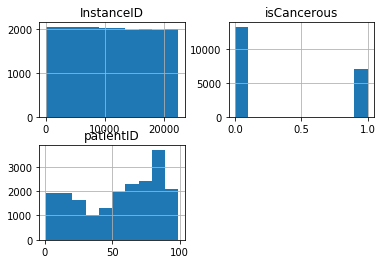

In [95]:
mainData.hist()
plt.show()

In [96]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['cellType'], axis=1,inplace=True)
mainData.drop(['cellTypeName'], axis=1,inplace=True)


In [97]:
mainData['isCancerous'] = mainData['isCancerous'].astype('category')


In [98]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   patientID    20280 non-null  int64   
 1   ImageName    20280 non-null  object  
 2   isCancerous  20280 non-null  category
dtypes: category(1), int64(1), object(1)
memory usage: 336.9+ KB


In [99]:
mainData.isnull().sum()

patientID      0
ImageName      0
isCancerous    0
dtype: int64

**There are no missing values in the datasets.**

In [134]:
def BinBreakdown(desc, data):
    neg, pos = np.bincount(data)
    total = neg + pos
    print('{} Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(desc, total, pos, 100 * pos / total))

In [136]:
BinBreakdown('Input Data', mainData.isCancerous)

Input Data Class Data:
    Total: 20280
    Positive: 7069 (34.86% of total)



#### Key observations:
* Data has 20280  observations and 6 columns.
* InstanceID - is Id field, need to remove as not valueable classification attribute
* cellTypeName, cellType - indicator of actual cell type and not used in this case for cancer diagnosis
* isCancerous - indicator of the actual diagnosis (1 = cancerous, 0 = benign)
* image count matches data rows 

Split of benign to cancerous is a 35% cancerous, 65% benign

* The class value is boolean so doesn't have outliers etc to consider

# Train/Validation/Test Split on Patients

### Add classification class

In [102]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

### Split Data into Train/Validate/Test
For test and training data split via person.
This assumes that if a person has cancer or not, then would the images for that person have cancer.
Also different cell types per person would be used for validation/testing.

In [103]:
# Get list of patients and observation counts
# Allocate approc 25% of data for Validation and Testing - of that 60%/40% for validation/test split.
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [104]:
# Split train tests by ratios
# Select random patients until the number of images for 
# each patient sums to the number of records require

np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())

# Loop through selecting a patient at random summing the number of images they have
# until the count of images crosses is more than required number

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [105]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [115]:
totalRecs = mainData.shape[0]
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))
print("Train data : {:.2f}%, Val Data: {:.2f}%, Test Data: {:.2f}%".format(
    100 * trainData.shape[0] / totalRecs, 100 * valData.shape[0]/totalRecs, 100 * testData.shape[0]/totalRecs))

Train data : 15054, Val Data: 3055, Test Data: 2171
Train data : 74.23%, Val Data: 15.06%, Test Data: 10.71%


In [116]:
trainData.head()

,patientID,ImageName,isCancerous
19,2,19035.png,0
20,2,19036.png,0
21,2,19037.png,0
22,2,19038.png,0
23,2,19039.png,0


In [137]:
BinBreakdown('Train', trainData.isCancerous)
BinBreakdown('Validation', valData.isCancerous)
BinBreakdown('Test', testData.isCancerous)

Train Class Data:
    Total: 15054
    Positive: 5264 (34.97% of total)

Validation Class Data:
    Total: 3055
    Positive: 1096 (35.88% of total)

Test Class Data:
    Total: 2171
    Positive: 709 (32.66% of total)



([0, 1], <a list of 2 Text xticklabel objects>)

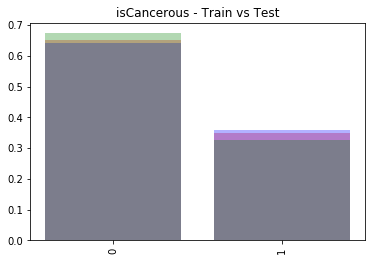

In [117]:
plt.bar(
    trainData.isCancerous.value_counts().index.astype(str), 
    trainData.isCancerous.value_counts().values/np.sum(trainData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='r')

plt.bar(
    valData.isCancerous.value_counts().index.astype(str), 
    valData.isCancerous.value_counts().values/np.sum(valData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='b')

plt.bar(
    testData.isCancerous.value_counts().index.astype(str), 
    testData.isCancerous.value_counts().values/np.sum(testData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='g')

plt.title('isCancerous - Train vs Test')
plt.xticks(rotation='vertical')

**Observations:**
1. Train/Validation/Test data distributions sets have similar distributions

# Images
27x27 RGB 

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 1426 validated image filenames belonging to 2 classes.
Found 341 validated image filenames belonging to 2 classes.
Found 233 validated image filenames belonging to 2 classes.


### Utility Functions

In [25]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [26]:
def PlotModelFitHistory(mh):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(mh.history['loss'], 'r--')
    plt.plot(mh.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(mh.history['binary_accuracy'], 'r--')
    plt.plot(mh.history['val_binary_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


In [27]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Model Development

### Measure 
As this is a screening task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

Model output is boolean so need to use sigmoid function as probability output of model

### Model Inputs

In [28]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

## 1. Baseline an simple MLP Model
Observations
* Use a initial NN to get a baseline
* Binary classification problem
* Input has 2187 dims (this is small for image recognition)
* 1 hidden layer with 256 internal nodes
* 1 output binary
* Loss - Binary Cross Entropy
* Metric - binary_accuracy 
* use sigmoid activation as this is a logistics issue



In [29]:
import tensorflow as tf

model_base = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='sigmoid')
])

In [30]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_base.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [32]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_base = model_base.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

15:38:36
15:40:25
Took =  0:01:49.032962


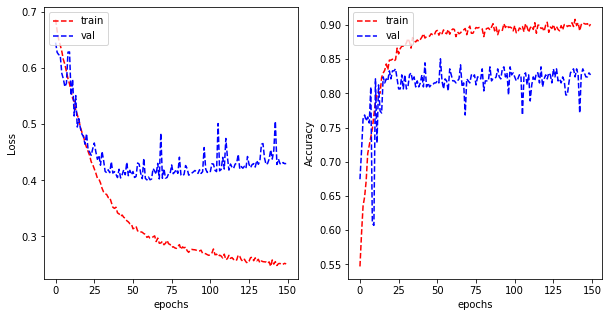

In [33]:
PlotModelFitHistory(history_base)


In [34]:
test_y = testData['isCancerous'].astype('int')

pred_y_base = model_base.predict(test_generator, batch_size=64, verbose=1)
pred_y_base = np.argmax(pred_y_base, axis=1)


8/8 [==============================] - 0s 14ms/step


In [35]:
print(classification_report(test_y, pred_y_base, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       182
           1       0.00      0.00      0.00        51

    accuracy                           0.78       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.61      0.78      0.69       233



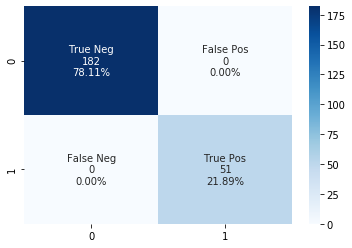

In [36]:
PlotConfusionMatrix(test_y, pred_y_base)

### Observation
* Train vs Validation approaches at 150 epocs
* There is significant overfitting of model after a short number of epochs
* Recall is good (?) maybe too good 
* Precision good at 0.40
* F1 score low at 0.64
* Accuracy reflects good recal and precision
* Instability in accuracy could indicate too high learning rate


## 2. Base Model with regularisation
To reduce overfitting try regularisation

In [122]:
# Use default lambda - note for assignment only. In real this might be in loop to determine best value.
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [120]:
model_reg.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [121]:
model_reg.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [40]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_reg = model_reg.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)


15:40:25
15:41:41
Took =  0:01:15.776101


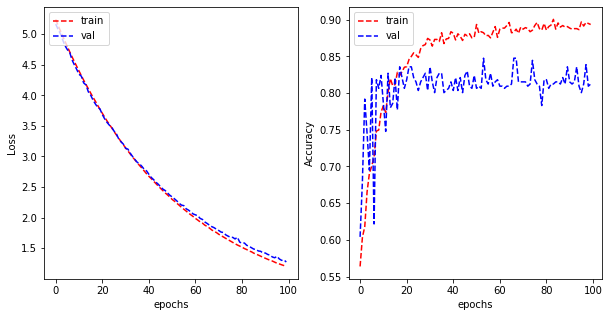

In [41]:
PlotModelFitHistory(history_reg)


In [42]:
pred_y_reg = model_reg.predict(test_generator, batch_size=64, verbose=1)
pred_y_reg = np.argmax(pred_y_reg, axis=1)

8/8 [==============================] - 0s 11ms/step


In [43]:
print(classification_report(test_y, pred_y_reg, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       182
           1       0.00      0.00      0.00        51

    accuracy                           0.78       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.61      0.78      0.69       233



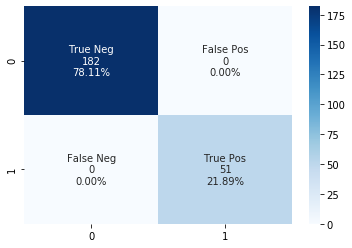

In [44]:
PlotConfusionMatrix(test_y, pred_y_reg)

### Observation
* Loss vs Epochs plot shows significantly improved fitting
* Accuracy stablises at ~ 80% after 20 epochs
* Learning rate maybe still high but results good
* Recall is good 
* Precision good at 0.40
* F1 score low at 0.64
* Accuracy reflects good recal and precision

Over all a better model than base

## 3. Base Model with dropout
To reduce overfitting and improve speed see if minor drop out improves the model.

In [45]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [46]:
model_drop.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [47]:
model_drop.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [48]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_drop = model_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

15:41:42
15:43:28
Took =  0:01:45.604316


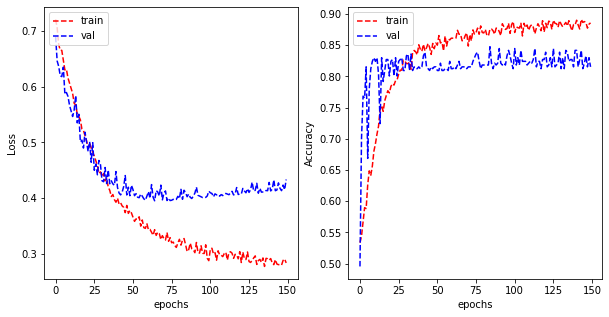

In [49]:
PlotModelFitHistory(history_drop)

In [50]:
pred_y_drop = model_drop.predict(test_generator, batch_size=64, verbose=1)
pred_y_drop = np.argmax(pred_y_drop, axis=1)

8/8 [==============================] - 0s 12ms/step


In [51]:
print(classification_report(test_y, pred_y_drop))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       182
           1       0.00      0.00      0.00        51

    accuracy                           0.78       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.61      0.78      0.69       233



C:\bin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


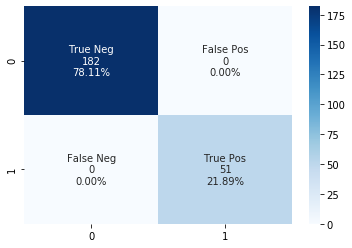

In [52]:
PlotConfusionMatrix(test_y, pred_y_drop)

### Observation
* Dropout also improves but test data looks to be better than training
* This may be result of the data but there also looks to be some overfitting
* This doesn't appear to improve on model 3

## 4. Baseline Plus VGG
Using an initial set of convolution layers may improve input to the MLP layers
Use standard VGG architecture to check if this provides better results

In [53]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [54]:
model_VGG_1.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [55]:
model_VGG_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

In [56]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

15:43:29
15:49:07
Took =  0:05:38.274955


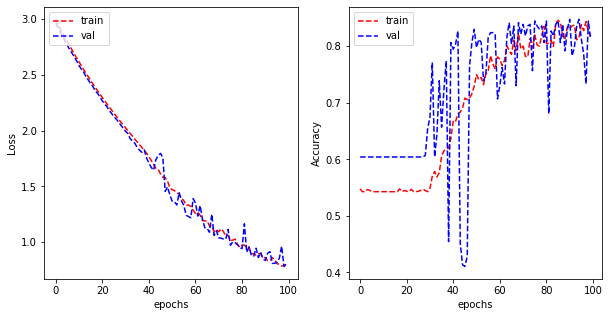

In [57]:
PlotModelFitHistory(history_VGG_1)

In [58]:
pred_y_vgg1 = model_VGG_1.predict(test_generator, batch_size=64, verbose=1)
pred_y_vgg1 = np.argmax(pred_y_vgg1, axis=1)

8/8 [==============================] - 0s 20ms/step


In [59]:
print(classification_report(test_y, pred_y_vgg1, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       182
           1       0.00      0.00      0.00        51

    accuracy                           0.78       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.61      0.78      0.69       233



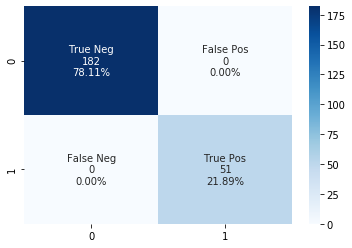

In [60]:
PlotConfusionMatrix(test_y, pred_y_vgg1)

### Observation
Issue is over fitting 
* This model took much longer to train.
* Reviewing the input size that VGG was designed for the number of inputs is much reduced.
* Lets reduce the number of convolutions layers and converlutions in the layer to improve training times.

## 5. VGG 2 with simplified convolutions
* We have 20k images so that should be ok for training
* image size is small so down scaling is not too beneficial
* after 40 epics so could stop early 
* over fitting so reduce the number of convolutions
* Given number of images, data augmentation probably not required


In [61]:
model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),

    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [62]:
model_VGG_2.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [63]:
model_VGG_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

In [64]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

15:49:08
15:51:29
Took =  0:02:21.159487


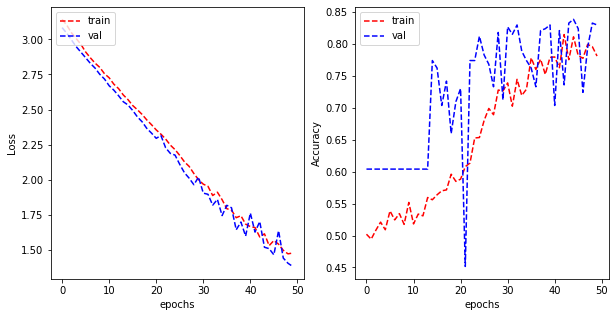

In [65]:
PlotModelFitHistory(history_VGG_2)

In [66]:
pred_y_vgg2 = model_VGG_2.predict(test_generator, batch_size=64, verbose=1)
pred_y_vgg2 = np.argmax(pred_y_vgg2, axis=1)

8/8 [==============================] - 0s 15ms/step


In [67]:
print(classification_report(test_y, pred_y_vgg2, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       182
           1       0.00      0.00      0.00        51

    accuracy                           0.78       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.61      0.78      0.69       233



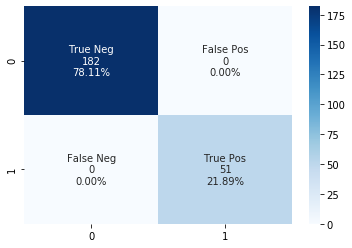

In [68]:
PlotConfusionMatrix(test_y, pred_y_vgg2)

### Observations
* The model still took a long time to train
* There looks to be minimal overfitting
* Reducing the number of epochs to 50 showed minimal loss issues but accuracy was jumbled

## 6. SC-CNN 
* Try model based on SC-CNN 
* We have 20k images so that should be ok for training

In [127]:
model_SC_CNN_1 = tf.keras.Sequential([
    # Convolution
    
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [128]:
model_SC_CNN_1.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [129]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_SC_CNN_1 = model_SC_CNN_1.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

23:09:57
23:10:56
Took =  0:00:59.209826


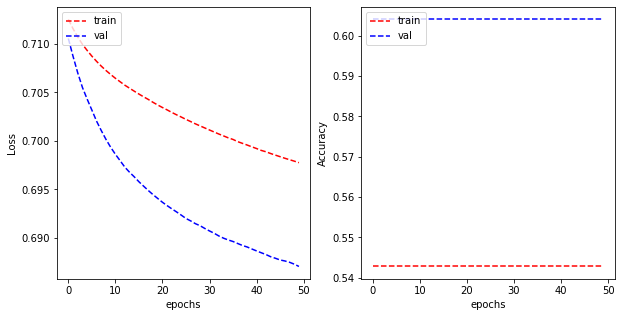

In [130]:
PlotModelFitHistory(history_SC_CNN_1)

In [131]:
pred_y_sc_cnn_1 = model_SC_CNN_1.predict(test_generator, batch_size=64, verbose=1)
pred_y_sc_cnn_1 = np.argmax(pred_y_sc_cnn_1, axis=1)

8/8 [==============================] - 0s 32ms/step


In [67]:
print(classification_report(test_y, pred_y_sc_cnn_1, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       182
           1       0.00      0.00      0.00        51

    accuracy                           0.78       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.61      0.78      0.69       233



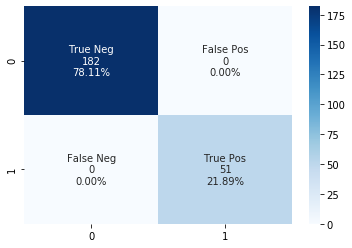

In [132]:
PlotConfusionMatrix(test_y, pred_y_sc_cnn_1)

### Observations
* The model overfitted significantly
* Accuracy not correct

# Model comparison and ultimate judgment

The base MLP model show overfitting
Using Regularistion resulted in a better model
Applying dropout also reduced overfitting but not the the same extent as regularisation 

Using the base VGG achitecture resulted in a small amount of overfitting
As the size of the inputs are quite low reducing the number of convolutions and adding some regulariation in the final MLP 
latyer might create a better model. 

All base models showed good results with 100% recall
Given the training time and simplicity the MLP with regularisation would be the best model

# Questions
* Results are the same for all models - looks bad but I can work out why
* accuracy jumps around but how to set learning rate?